In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import operator

## Bayesian inference

### Lineáris adat

Adott egy zajos egyenes, melynek szeretnénk megtudni mind a meredekségét, mind a zajnak a mértékét.

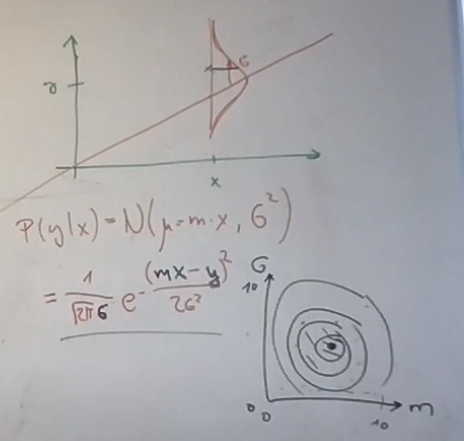

In [ ]:
theta_true = 1 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 5 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + np.random.normal(0,sigma_true,m)

In [ ]:
Normal = lambda  sigma, mu, y :  1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(y - mu)**2/(2*sigma**2))

### Lináris adat első próbálkozás

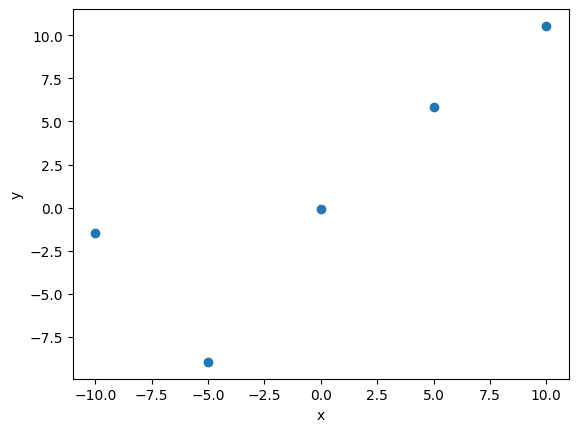

In [ ]:
theta_true = 1 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 5 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + np.random.normal(0,sigma_true,m)

# egyenes ábrázolása
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
sigmas = np.arange(2, 10, 0.05)
thetas = np.arange(0.1, 2, 0.02)
prior = np.ones((len(thetas),len(sigmas)))
prior /=np.sum(prior)


In [ ]:
def calculate_log_likelihood_for_datapoint(x_i,y_i):
  epsilon = 1e-8  # ez azért kell, hogy ne vegyük 0nak a logritmusát..
  log_likelihood_i = np.array([[np.log(Normal( sigma, x_i * theta, y_i ) + epsilon) for sigma in sigmas] for theta in thetas])
  return log_likelihood_i

In [ ]:
log_likelihood = sum([calculate_log_likelihood_for_datapoint(x[i],y[i]) for i in range(len(x))])
unnorm_log_posterior = np.log(prior) + log_likelihood
unnorm_log_posterior = unnorm_log_posterior - np.max(unnorm_log_posterior)
MUALP_estimate = np.where(unnorm_log_posterior==np.max(unnorm_log_posterior)) # maximum nem normalizált log poszterior becslése az eredeti egyenesnek
MUALP_estimate

(array([34]), array([38]))

Azért vettem a log-ját a valószínúségeknek, mert annyira kicsiek voltak, hogy összeszorozva 0nak vette a python. Illetve ezért nem normalizáltam, az unnorm_log_posterior-okat, mert azokat is 0nak venné..

In [ ]:
print("theta: ", thetas[MUALP_estimate[0][0]], "sigma: ", sigmas[MUALP_estimate[1][0]])

theta:  0.7800000000000001 sigma:  3.8999999999999932


Az alábbi ábrán ábrázolom a kapott valószínúségi eloszlást egy színtérképpel. Kék ponttal ábrázolom, a legjobb becslésünket. Látszik, hogy visszakaptuk az eredeti paramétereit az egyenesnek.

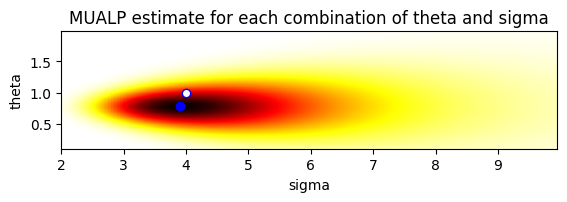

In [ ]:

plt.imshow(np.exp(unnorm_log_posterior), cmap='hot_r', origin='lower', extent=[sigmas[0], sigmas[-1], thetas[0], thetas[-1]])
plt.xlabel('sigma')
plt.ylabel('theta')
# plt.xticks(np.arange(0,11,1), np.arange(0.5,6,0.5))
# plt.yticks(np.arange(0,11,1), np.arange(0.5,6,0.5))
plt.scatter(sigmas[MUALP_estimate[1][0]], thetas[MUALP_estimate[0][0]], color='blue', label='MAP estimate')
plt.scatter(sigma_true, theta_true, edgecolor='blue', facecolor='w', label='true')
plt.title('MUALP estimate for each combination of theta and sigma')
# plt.legend(loc='upper left')
plt.show()

### Lineáris adat egy függvénnyel
Nem hiszem, hogy gyorsabb viszont egyértelműbb mint a fenti és akármennyi paraméterrel használható

In [ ]:
def bayesian_updating(x,y, prior, parameter_start, parameter_end, parameter_steps, assumed_true_mapping):
  for x_i, y_i in zip(x,y):
    for el in np.ndenumerate(prior):
      idx = el[0]
      parameters = parameter_start + parameter_steps * np.array(idx)
      epsilon = 1e-8  # ez azért kell, hogy ne vegyük 0nak a logritmusát..
      prior[idx] += np.log(Normal(parameters[-1], assumed_true_mapping(x_i, parameters), y_i) + epsilon)

  unnorm_posterior = np.exp(prior-np.max(prior))
  posterior = unnorm_posterior / np.max(unnorm_posterior)
  return posterior

In [ ]:
# egyenként lehet definiálni a paraméterekre, hogy hol kezdődnek, hol végződnek és mekkora lépések vannak köztük
parameter_start = np.array([0.1, 0.1])
parameter_end = np.array([4,10])
parameter_steps = np.array([0.1,0.1])
parameter_shapes = np.array((parameter_end - parameter_start)/parameter_steps,dtype=int)

assumed_true_mapping = lambda x, parameters : parameters[0] * x # ez az a leképezés, amit feltételezünk, a likelihood-ok számolásánál
prior = np.log(np.ones(parameter_shapes)/np.product(parameter_shapes)) # prior, én uniformnak vettem
posterior = bayesian_updating(x,y,prior, parameter_start,parameter_end,parameter_steps, assumed_true_mapping)

MAP_estimate = np.where(posterior==np.max(posterior)) # látszik, hogy ugyanaz mint a fentebbiekben
print("theta: ",  MAP_estimate[0] * parameter_steps[0] + parameter_start[0], "sigma: ", MAP_estimate[1] * parameter_steps[1] + parameter_start[1])

theta:  [0.8] sigma:  [3.9]


#### Kérdés: függ a meredekségre kapott megoldás a sigma értékétől?


úgy értem, hogy a sigmára kapott becslés értékétől függ-e a theta becsült értéke?

In [ ]:
parameter_start = np.array([0.1, 0.1])
parameter_end = np.array([4,10])
parameter_steps = np.array([0.1,0.1])
parameter_shapes = np.array((parameter_end - parameter_start)/parameter_steps,dtype=int)

assumed_true_mapping = lambda x, parameters : parameters[0] * x # ez az a leképezés, amit feltételezünk, a likelihood-ok számolásánál
delta_theta = []
delta_sigma = []
for sigma_true_i in np.arange(0.1,10,0.5):
  theta_true = 1 # az egyenesünk egy darab paramétere
  m = 5 # adatpontok száma
  x = np.linspace(-10,10,m)
  y = theta_true*x + np.random.normal(0,sigma_true_i,m)

  prior = np.log(np.ones(parameter_shapes)/np.product(parameter_shapes)) # prior, én uniformnak vettem
  posterior = bayesian_updating(x,y,prior, parameter_start,parameter_end,parameter_steps, assumed_true_mapping)
  MAP_estimate = np.where(posterior==np.max(posterior))

  theta_h = MAP_estimate[0] * parameter_steps[0] + parameter_start[0]
  sigma_h = MAP_estimate[1] * parameter_steps[1] + parameter_start[1]

  delta_theta.append(abs(theta_true-theta_h))
  delta_sigma.append(abs(sigma_true_i-sigma_h))

Szerintem annak, hogy mennyire jól becsüli meg a modellünk a paraméterek(pl.theta) értékeit, nem kellene fügnie egy adott paraméter értékétől(pl.sigma). Mégis, ezen a szimuláción, meg az látszik, hogy nem monoton, de nő az eltérések értéke. Viszont ez lehet azért is, mert egyszerűen egy zajosabb leképezéshez több adatpontra lenne szükségünk, hogy megbecsüljük.

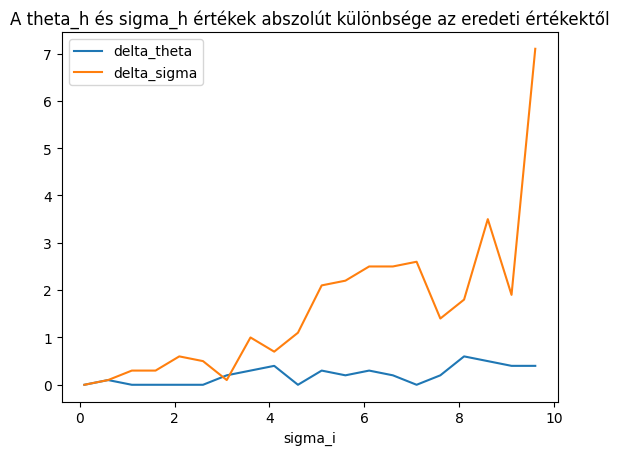

In [ ]:
plt.plot(np.arange(.1, 10, .5), delta_theta)
plt.plot(np.arange(.1, 10, .5), delta_sigma)
plt.title("A theta_h és sigma_h értékek abszolút különbsége az eredeti értékektől")
plt.legend(["delta_theta", "delta_sigma"])
plt.xlabel("sigma_i")
plt.show()

#### 1. Megcsinálni ugyanezt (Bayesian model fitting) meredekség és tengelymetszetre.
Én zaj nélkül, annyira nem látom, hogy például hogy számolnám ki a likelihood-ot. Meg ha nincs zaj, akkor 2 adatpontból meg lehet mondani a meredekséget és a tengelymetszetet is. Esetleg meg lehet nézni nagyon alacsony zajra

#### 2.~ meredekség, tengelymetszet és zaj-ra.

In [ ]:
theta_true = 1 # az egyenesünk eg darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
b = 2
m = 20 # adatpontok száma
x = np.linspace(-10,10,m)
y = b+theta_true*x + np.random.normal(0,sigma_true,m)
# egyenként lehet definiálni a paraméterekre, hogy hol kezdődnek, hol végződnek és mekkora lépések vannak köztük
parameter_start = np.array([0.1, 0.1,0.1])
parameter_end = np.array([4,4,10])
parameter_steps = np.array([0.1,0.1,0.1])
parameter_shapes = np.array((parameter_end - parameter_start)/parameter_steps,dtype=int)

assumed_true_mapping = lambda x, parameters : parameters[0]+parameters[1] * x # ez az a leképezés, amit feltételezünk, a likelihood-ok számolásánál
prior = np.log(np.ones(parameter_shapes)/np.product(parameter_shapes)) # prior, én uniformnak vettem
posterior = bayesian_updating(x,y,prior, parameter_start,parameter_end,parameter_steps, assumed_true_mapping)

MAP_estimate = np.where(posterior==np.max(posterior)) # látszik, hogy ugyanaz mint a fentebbiekben
print(np.array(MAP_estimate)*0.1+0.1)

[[3.1]
 [1.2]
 [4.3]]


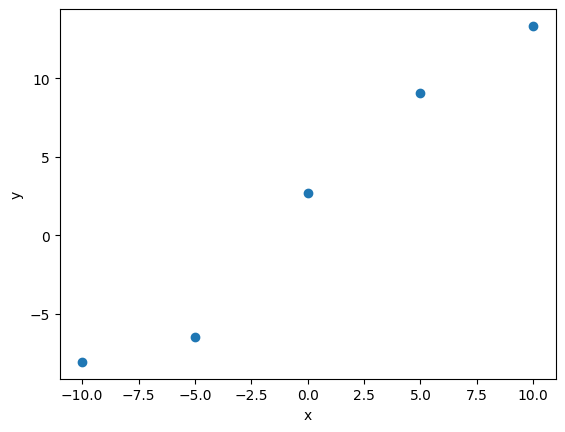

In [ ]:
theta_true = 1 # az egyenesünk egy darab paramétere
beta_true = 1 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 5 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + beta_true + np.random.normal(0,sigma_true,m)

# egyenes ábrázolása
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 3.~ szigmoid függvény
- becsüld a szigmoid paramétereit (amplitudó, küszöb, slope + esetleg zaj), de zaj csak a kimeneten van.
- ha nehéz, akkor mondd azt, hogy mondjuk az emplitudót (vagy a slope-ot is) ismered
- hasonlitsd össze, hogy mit kapsz sima least square-rel.


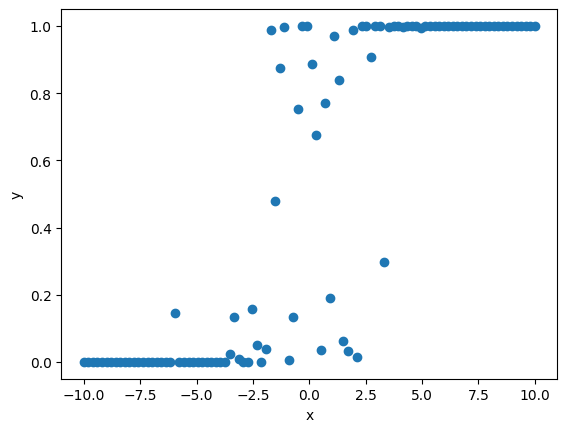

In [15]:
import numpy as np
import matplotlib.pyplot as plt
sigmoid = lambda x: 1/(1+np.exp(-x))
theta_true = 2 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 100 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + np.random.normal(0,sigma_true,m)

# egyenes ábrázolása
plt.scatter(x,sigmoid(x*theta_true + np.random.normal(0, sigma_true, m)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 4.~ szigmoid függvény, zaj a bemeneten
- becsüld a szigmoid paramétereit (amplitudó, küszöb, slope + zaj), de zaj csak a bemeneten van.
- ha nehéz, akkor mondd azt, hogy mondjuk az emplitudót (vagy a slope-ot is) ismered
- hasonlitsd össze, hogy mit kapsz sima least square-rel.

#### 5.~ szigmoid függvény, zaj a bemeneten és a kimeneten is

## Egyéb